Before running:
*   SLImages should be in a folder called `Images`
*   SATImages should be in a folder called `SATimages`
*   Data file should be saved as `ec2355_full_data.csv`




In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.5 MB/s eta 0:00:00


In [4]:
import numpy as np
from transformers import Swinv2Config, Swinv2Model, AutoImageProcessor
import torch
from PIL import Image
import os
import pandas as pd
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load images

In [5]:
!unzip SLImages.zip
!unzip SATImages.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/pic_HA1 4RP_0.jpg  
  inflating: Images/pic_SE2 0AA_0.jpg  
  inflating: Images/pic_SE9 4DG_180.jpg  
  inflating: Images/pic_E3  4AS_0.jpg  
  inflating: Images/pic_W10 5TZ_0.jpg  
  inflating: Images/pic_SW120BS_0.jpg  
  inflating: Images/pic_N19 5BP_90.jpg  
  inflating: Images/pic_SE114BF_270.jpg  
  inflating: Images/pic_UB4 9AZ_270.jpg  
  inflating: Images/pic_BR1 5EY_180.jpg  
  inflating: Images/pic_W11 1PN_90.jpg  
  inflating: Images/pic_SE5 8EL_180.jpg  
  inflating: Images/pic_E17 8JX_270.jpg  
  inflating: Images/pic_NW8 8QH_270.jpg  
  inflating: Images/pic_EC1V2AB_90.jpg  
  inflating: Images/pic_NW6 1AL_90.jpg  
  inflating: Images/pic_W10 5UN_180.jpg  
  inflating: Images/pic_SW6 6HP_270.jpg  
  inflating: Images/pic_SE146AN_90.jpg  
  inflating: Images/pic_W5  4BF_0.jpg  
  inflating: Images/pic_HA9 6AD_270.jpg  
  inflating: Images/pic_E9  7BZ_0.jpg  
  inflating: Images/pic_UB108BJ_0.jpg  
  in

In [6]:
SLimages = os.listdir('Images')
SLimages.sort()
# SLimage_codes = [image.split("_")[1] for image in SLimages]

In [7]:
SATimages = os.listdir('SATimages')
SATimages.sort()
# SATimage_codes = [image.split("_")[1] for image in SATimages]

In [8]:
images = []
image_codes = []
for i, img in enumerate(SATimages):
  SAT_pcd = img.split("_")[1]
  SL_imgs = [i for i in SLimages if SAT_pcd in i]
  if len(SL_imgs) == 4:
    images.extend(SL_imgs)
    images.append(img)
    image_codes.append(SAT_pcd)

In [9]:
num_imgs = len(images)
print(num_imgs)

18150


In [10]:
images = np.reshape(images,(363,50))

# SWIN Transformer

In [11]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
model = model.cuda()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 were not used when initializing Swinv2Model: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing Swinv2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Swinv2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
final_reps = []

for batch in tqdm(images):
  num_batch = len(batch)
  
  # Load images for this batch
  ims = []
  for i, image_label in enumerate(batch):
    if (i + 1) % 5 != 0: # image_label describes a SL image
      ims.append(Image.open("Images/"+image_label))
    else: # image_label describes a SAT image
      ims.append(Image.open("SATimages/"+image_label))
  inputs = image_processor(ims, return_tensors="pt")['pixel_values']

  # Generate vectorized representations using SWIN
  with torch.no_grad():
    inputs = inputs.cuda()
    outputs = model(inputs)
  pooled_output = (outputs.pooler_output).cpu().detach().numpy()
  final_outputs = np.reshape(pooled_output,(int(num_batch/5),5,768))
  final_outputs = np.reshape(final_outputs,(int(num_batch/5),5*768))
  final_reps.append(final_outputs)

final_reps = np.array(final_reps)
final_reps = np.reshape(final_reps,(int(num_imgs/5),5*768))
np.savetxt('final_reps.csv',final_reps,delimiter = ',')

100%|██████████| 363/363 [03:54<00:00,  1.55it/s]


# Feed-forward NN

In [13]:
image_reps = np.loadtxt("final_reps.csv", delimiter = ",", dtype = "float")

In [105]:
pcd_income_data = pd.read_csv("ec2355_full_data.csv")
pcd_income_data = pcd_income_data.sort_values(by = "postcode")
labels = pcd_income_data[pcd_income_data["postcode"].isin(image_codes)]
labels = np.array(labels.iloc[:,6]) - 1 # index deciles from 0 to 9; use `:,4` for income, `:,6` for overcrowding, , `:,9` for deprivation

In [106]:
class StreetRepsDataset(Dataset):
  def __init__(self, label_set, image_reps):
    self.labels = labels
    self.image_reps = image_reps
  def __len__(self):
    return self.image_reps.shape[0]
  def __getitem__(self, idx):
    return self.image_reps[idx], self.labels[idx]

In [107]:
data = StreetRepsDataset(labels,image_reps)

# Split the dataset into three with the provided sizes
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1])

# Change `*_batch_size` here if required
train_batch_size = 16
val_batch_size = 16
test_batch_size = 1

# Create dataloader objects
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = val_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle=True)

In [108]:
class DecilePred(torch.nn.Module):
  #This is adapted from the Esra Suel methodology
  def __init__(self, n_in, n_out): 
    super(DecilePred, self).__init__()
    self.dense1 = torch.nn.Linear(n_in, 512)
    self.dense2 = torch.nn.Linear(512, 256)
    self.dense3 = torch.nn.Linear(256, 128)
    self.dense4 = torch.nn.Linear(128, 64)
    self.dense5 = torch.nn.Linear(64, n_out)
    self.softmax = torch.nn.Softmax()
    self.relu = torch.nn.ReLU()

  def forward(self, x1): 
    # first layer
    x1 = self.relu(self.dense1(x1))
    # second layer
    x1 = self.relu(self.dense2(x1))
    # third layer
    x1 = self.relu(self.dense3(x1))
    # fourth layer
    x1 = self.relu(self.dense4(x1))
    # out layer
    out = self.dense5(x1)
    return self.softmax(out)

In [109]:
learning_rate = 0.0001
loss_fn = torch.nn.CrossEntropyLoss()
model = DecilePred(5*768, 10).double()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.0001)

In [ ]:
#Now we have our training loop
n_epochs = 30

model = model.cuda()

# Check zero-shot accuracy
model.eval()
n_correct = 0
mae = 0
for X, y in val_loader:
  X = X.cuda()
  output = model(X).cpu()
  _, pred = torch.max(output.detach(), 1)
  n_correct += torch.sum(torch.eq(pred, y)).item()
  mae += torch.sum(torch.abs(torch.sub(pred, y))).item()

print(f'Zero-shot: val accuracy: {(n_correct / len(val_dataset)):3f}, val MAE: {(mae / len(val_dataset)):3f}')

train_loss = []
val_acc = []
val_mae = []
for i in tqdm(range(n_epochs)):

  model.train()

  loss_sum = 0
  for X, y in train_loader:
    X = X.cuda()
    y = y.cuda()

    # Create predictions by running the model
    y_preds = model(X)

    # Compute the loss with the loss function defined above
    loss = loss_fn(y_preds, y)
    loss_sum += loss.item()

    # Zero the optimizer grads by calling optimizer.zero_grad()
    optimizer.zero_grad()

    # Call the `backward` function on the loss to compute the gradients
    loss.backward()

    # Call `step` on the optimzer to update the parameters
    optimizer.step()
  
  train_loss.append(loss_sum / len(train_loader))

  # Eval Step
  model.eval()
  n_correct = 0
  mae = 0
  for X, y in val_loader:
    X = X.cuda()
    output = model(X).cpu()
    _, pred = torch.max(output.detach(), 1)
    n_correct += torch.sum(torch.eq(pred, y)).item()
    mae += torch.sum(torch.abs(torch.sub(pred, y))).item()

  val_acc.append(n_correct / len(val_dataset))
  val_mae.append(mae / len(val_dataset))
  print(f'Epoch {i}: val accuracy: {(n_correct / len(val_dataset)):3f}, val MAE: {(mae / len(val_dataset)):3f}')

In [ ]:
model.eval()
n_correct = 0
mae = 0

with torch.no_grad():
  for X, y in test_loader:
    X = X.cuda()
    output = model(X).cpu()
    _, pred = torch.max(output.detach(), 1)
    print("pred:", pred.item(), ", y:", y.item())
    n_correct += torch.sum(torch.eq(pred, y)).item()
    mae += torch.sum(torch.abs(torch.sub(pred, y))).item()

print(f'Test accuracy: {(n_correct / len(test_dataset)):3f}')
print(f'Test MAE: {(mae / len(test_dataset)):3f}')

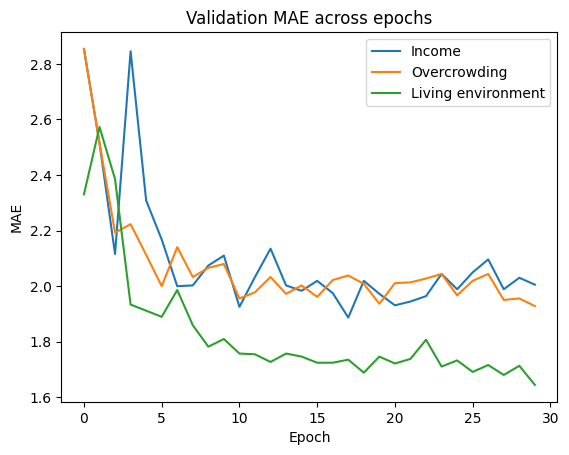

In [88]:
# plt.plot(income_val_mae, label="Income")
# plt.plot(overcrowding_val_mae, label="Overcrowding")
# plt.plot(env_val_mae, label="Living environment")
# plt.ylabel("MAE")
# plt.xlabel("Epoch")
# plt.title("Validation MAE across epochs")
# plt.legend()
# plt.savefig("val_mae.png")

# Collect results

In [49]:
import csv

data = StreetRepsDataset(labels,image_reps)

# Create dataloader objects
data_loader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle=False)

model.eval()
n_correct = 0
mae = 0

preds = []
maes = []
with torch.no_grad():
  for X, y in data_loader:
    X = X.cuda()
    output = model(X).cpu()
    _, pred = torch.max(output.detach(), 1)
    preds.append(pred.item() + 1)
    maes.append(torch.sum(torch.abs(torch.sub(pred, y))).item())

<ipython-input-42-7e0b1cff1069>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(out)


In [50]:
df = pcd_income_data[pcd_income_data["postcode"].isin(image_codes)]
df['pred_overcrowding'] = preds
df['mae_overcrowding'] = maes
df.to_csv('pred_overcrowding.csv', index=False)

<ipython-input-50-82ffe48d5bb3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_overcrowding'] = preds
<ipython-input-50-82ffe48d5bb3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mae_overcrowding'] = maes
